# LangGraph Retrieval GroundCheck

[검색 에이전트](https://python.langchain.com/docs/use_cases/question_answering/conversational_retrieval_agents)는 인덱스에서 검색할지 여부에 대한 결정을 내리고 싶을 때 유용합니다.

검색 에이전트를 구현하기 위해서는 LLM에 검색 도구에 대한 접근 권한을 제공하기만 하면 됩니다.

이를 [LangGraph](https://python.langchain.com/docs/langgraph)에 통합할 수 있습니다.

## 환경설정

In [ ]:
# api key
from dotenv import load_dotenv

load_dotenv()

In [ ]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LANGGRAPH")

In [3]:
from rag.pdf import PDFRetrievalChain

pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

## GraphState

각 노드에서 다음 노드로 전달되는 상태를 저장합니다.

In [4]:
from typing import TypedDict


# GraphState 상태를 저장하는 용도로 사용합니다.
class GraphState(TypedDict):
    question: str  # 질문
    context: str  # 문서의 검색 결과
    answer: str  # 답변
    relevance: str  # 답변의 문서에 대한 관련성

## 노드와 엣지

우리는 agentic RAG 그래프를 다음과 같이 구성할 수 있습니다:

- 상태는 메시지의 집합입니다
- 각 노드는 상태를 업데이트(추가)합니다
- 조건부 엣지는 다음에 방문할 노드를 결정합니다


In [5]:
from rag.utils import format_docs
from langchain_upstage import UpstageGroundednessCheck

# 업스테이지 문서 관련성 체크 기능을 설정합니다. https://upstage.ai
upstage_ground_checker = UpstageGroundednessCheck()

# 업스테이지 문서 관련성 체크를 실행합니다.
upstage_ground_checker.run(
    {
        "context": format_docs(
            pdf_retriever.invoke("삼성전자가 개발한 생성AI 의 이름은")
        ),
        "answer": "삼성전자가 개발한 생성AI 의 이름은 `빅스비 AI` 입니다.",
    }
)

'notGrounded'

In [6]:
# 문서에서 검색하여 관련성 있는 문서를 찾습니다.
def retrieve_document(state: GraphState) -> GraphState:
    # Question 에 대한 문서 검색을 retriever 로 수행합니다.
    retrieved_docs = pdf_retriever.invoke(state["question"])
    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=format_docs(retrieved_docs))


# Chain을 사용하여 답변을 생성합니다.
def llm_answer(state: GraphState) -> GraphState:
    return GraphState(
        answer=pdf_chain.invoke(
            {"question": state["question"], "context": state["context"]}
        )
    )

In [9]:
# 문서에서 검색하여 관련성 있는 문서를 찾습니다.
def retrieve_document(state: GraphState) -> GraphState:
    # Question 에 대한 문서 검색을 retriever 로 수행합니다.
    retrieved_docs = pdf_retriever.invoke(state["question"])
    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=format_docs(retrieved_docs))


# Chain을 사용하여 답변을 생성합니다.
def llm_answer(state: GraphState) -> GraphState:
    return GraphState(
        answer=pdf_chain.invoke(
            {"question": state["question"], "context": state["context"]}
        ),
        context=state["context"],
        question=state["question"],
    )


# 테스트용 더미 답변 생성 함수
def fake_llm_answer(state: GraphState) -> GraphState:
    return GraphState(
        answer="삼성전자가 개발한 생성AI 의 이름은 `빅스비 AI` 입니다.",
        context=state["context"],
        question=state["question"],
    )


# 관련성 체크를 실행합니다.
def relevance_check(state: GraphState) -> GraphState:
    # 관련성 체크를 실행합니다. 결과: grounded, notGrounded, notSure
    response = upstage_ground_checker.run(
        {"context": state["context"], "answer": state["answer"]}
    )
    return GraphState(
        relevance=response,
        context=state["context"],
        answer=state["answer"],
        question=state["question"],
    )


# 관련성 체크 결과를 반환합니다.
def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "grounded":
        return "관련성 O"
    elif state["relevance"] == "notGrounded":
        return "관련성 X"
    elif state["relevance"] == "notSure":
        return "확인불가"

## 그래프 정의

In [22]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("retrieve", retrieve_document)  # 에이전트 노드를 추가합니다.
workflow.add_node("llm_answer", llm_answer)  # 정보 검색 노드를 추가합니다.

# 테스트용 fake llm 을 추가합니다.
# workflow.add_node("llm_answer", fake_llm_answer)  # 정보 검색 노드를 추가합니다.


workflow.add_node(
    "relevance_check", relevance_check
)  # 답변의 문서에 대한 관련성 체크 노드를 추가합니다.

# 각 노드들을 연결합니다.
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", "relevance_check")  # 답변 -> 관련성 체크

# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "관련성 O": END,  # 관련성이 있으면 종료합니다.
        "관련성 X": "retrieve",  # 관련성이 없으면 다시 답변을 생성합니다.
        "확인불가": "retrieve",  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
    },
)

# 시작점을 설정합니다.
workflow.set_entry_point("retrieve")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
app = workflow.compile(checkpointer=memory)

## 그래프 시각화

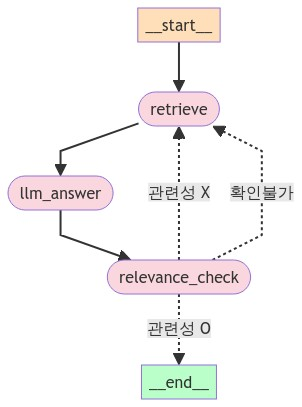

In [23]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [21]:
from langchain_core.runnables import RunnableConfig

# recursion_limit: 최대 반복 횟수, thread_id: 실행 ID (구분용)
config = RunnableConfig(recursion_limit=13, configurable={"thread_id": "SELF-RAG"})

# GraphState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(question="삼성전자가 개발한 생성형 AI의 이름은?")
output = app.invoke(inputs, config=config)

# 출력 결과를 확인합니다.
print("Question: \t", output["question"])
print("Answer: \t", output["answer"])
print("Relevance: \t", output["relevance"])

Question: 	 삼성전자가 개발한 생성형 AI의 이름은?
Answer: 	 삼성전자가 개발한 생성형 AI의 이름은 '삼성 가우스'입니다. (출처: data/SPRI_AI_Brief_2023년12월호_F.pdf, 페이지 13)
Relevance: 	 grounded


In [16]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=13, configurable={"thread_id": "SELF-RAG"})

# GraphState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(question="삼성전자가 개발한 생성형 AI의 이름은?")

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"[NODE] {key}")
            for k, v in value.items():
                pprint.pprint(f"<{k}> {v}")
            pprint.pprint("===" * 10)
            # 출력 값을 예쁘게 출력합니다.
            # pprint.pprint(value, indent=2, width=80, depth=None)
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

'[NODE] retrieve'
('<context> <document><content>SPRi AI Brief |\n'
 '2023-12월호\n'
 '삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개\n'
 'KEY Contents\n'
 'n 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성\n'
 'AI 모델 ‘삼성 가우스’를 공개\n'
 'n 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한\n'
 '삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유\n'
 '£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원\n'
 'n 삼성전자가 2023년 11월 8일 열린 ‘삼성 AI 포럼 2023’ 행사에서 자체 개발한 생성 AI 모델\n'
 '‘삼성 가우스’를 최초 공개\n'
 '∙ 정규분포 이론을 정립한 천재 수학자 가우스(Gauss)의 이름을 본뜬 삼성 가우스는 다양한 상황에\n'
 '최적화된 크기의 모델 선택이 가능\n'
 '∙ 삼성 가우스는 라이선스나 개인정보를 침해하지 않는 안전한 데이터를 통해 '
 '학습되었으며,</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>13</page></document>\n'
 '<document><content>형식의 텍스트 생성에서도 GPT-4에 준하는 성능을 기록했으나, RAG 포함 질문과 답변에서는 허깅\n'
 '페이스의 제퍼(Zephyr-7b)가 라마2를 능가\n'
 '<갈릴레오의 LLM 환각 지수(RAG 포함 질문과 답변 기준)>\n'
 '☞ 출처: Galileo, LLM Hallucination Index, '
 '2023.11.15.</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>20</page></document>\n'
 '<d

In [15]:
print("Question: \t", output["relevance_check"]["question"])
print("Answer: \t", output["relevance_check"]["answer"])
print("Relevance: \t", output["relevance_check"]["relevance"])

Question: 	 삼성전자가 개발한 생성형 AI의 이름은?
Answer: 	 삼성전자가 개발한 생성형 AI의 이름은 '삼성 가우스'입니다. (출처: data/SPRI_AI_Brief_2023년12월호_F.pdf, 페이지 13)
Relevance: 	 grounded


## LangSmith 추적

- Fake LLM 고의로 Hallucination 생성 결과: https://smith.langchain.com/public/a8adbfb2-c3b7-423b-aa0c-b10e7becd748/r
- 정상 결과: https://smith.langchain.com/public/c478252b-83f9-40e0-a45f-3bdbf1180bdc/r